# Stock forecasting
## Author: Hoang Van Phan

In this notebook, I will try a few models to predict stock daily close price up until 8/1/2020.

In [1]:
# Import packages
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import yfinance as yf # for downloading stock price from Yahoo Finance

from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Save a list of nice looking colors
my_colors = plt.get_cmap('tab10')

# Timestamp
print(f"========== Notebook executed on {datetime.now().replace(microsecond=0)} ==========")

========== Notebook executed on 2020-09-07 10:10:27 ==========


## Prepare the data

I will use all available data after 2000, because this period should cover most of the possible trends, such as the crashes in 2008 and 2020

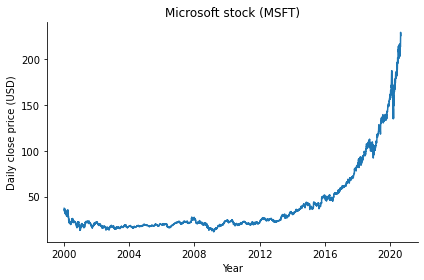

In [2]:
# Pick Microsoft stock
stock = yf.Ticker("MSFT")
stock_hist = stock.history(start="2000-01-01", end="2020-09-01")
stock_date = stock_hist.index
# convert close price to numpy array
stock_price = stock_hist["Close"].to_numpy()

# Plot
fig, ax = plt.subplots(tight_layout=True)
ax.plot(stock_date, stock_price)
ax.set_xlabel("Year")
ax.set_ylabel("Daily close price (USD)")
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title("Microsoft stock (MSFT)")
sns.despine(fig=fig)

## ARIMA model

#### Forecast stock price

First, I will use ARIMA to forecast stock price for 10 days after 7/1/2020, using the stock price data between 7/1/2019-6/30/2020 as the training data. The parameters of the model are chosen arbitrarily to be (5,1,1).

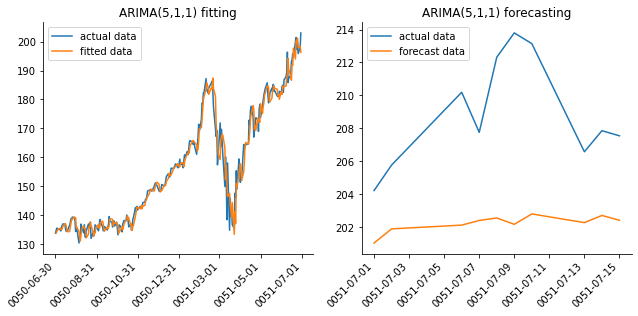

In [3]:
# Training period: 8/1/2019-7/31/2020
train_1year = (stock_date >= datetime.fromisoformat("2019-07-01")) & (stock_date < datetime.fromisoformat("2020-07-01"))
# validation period
validation_date = (stock_date >= datetime.fromisoformat("2020-07-01"))

# Fit the model
model = ARIMA(stock_price[train_1year], order=(5,1,1))
model_fit = model.fit()
# In-sample prediction and out-of-sample forecasting
model_predict = model_fit.predict()
model_forecast = model_fit.forecast(steps=10)

# Plot
fig, ax = plt.subplots(ncols=2, figsize=(9,4.5), tight_layout=True)
ax[0].plot(stock_date[train_1year], stock_price[train_1year], label="actual data")
ax[0].plot(stock_date[train_1year][1:], model_predict[1:], label="fitted data")
ax[0].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[0].get_xticks()],
                      rotation=45, ha='right')
ax[0].set_title("ARIMA(5,1,1) fitting")
ax[0].legend(loc="best")
ax[1].plot(stock_date[validation_date][:10], stock_price[validation_date][:10], label="actual data")
ax[1].plot(stock_date[validation_date][:10], model_forecast, label="forecast data")
ax[1].set_xticklabels([datetime.fromordinal(int(s)).date() for s in ax[1].get_xticks()],
                      rotation=45, ha='right')
ax[1].set_title("ARIMA(5,1,1) forecasting")
ax[1].legend(loc="best")
sns.despine(fig=fig)

While the fitted data looks very good, the 10 days forecast data is not. The model predicts a flat trend, compared to an actual rise and fall of stock price. The bad performance of the forecast can be caused by the bad choice of model parameters.

Therefore, I will perform a grid search of model parameters as following. The ARIMA model with a set of parameters is first trained using the most recent 260 days (approximately 1 year of business days) of data, and forecast the price of the next 3 days. Then, the model takes one step forward, and repeat the training/forecasting process. This process of training and forecasting the next day will be repeated 10 times beginning of 6/1/2020, and for different sets of parameters. The best model parameters will be the one that has the lowest sum of squared residuals (SSR) between all actual and forecast values.

In [4]:
# Grid search for optimal parameters using validation data
validate_date = (stock_date >= datetime.fromisoformat("2020-06-01"))
SSR = {}
for p in range(5):
    for d in range(3):
        for q in range(3):
            if (p==0) & (d==0) & (q==0):
                continue
            
            SSR_temp = []
            for i in np.arange(stock_date.shape[0])[validate_date][:10]:
                model = ARIMA(stock_price[(i-260):i], order=(p,d,q))
                model_fit = model.fit()
                ypred = model_fit.forecast(steps=3)
                SSR_temp.extend(list((ypred - stock_price[i:(i+3)])**2))
                
            SSR[(p,d,q)] = np.sum(np.array(SSR_temp))

Best parameters: (p,d,q) = (0, 2, 2)


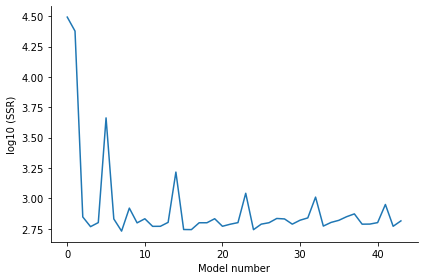

In [5]:
# Plot all SSR
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.log10(list(SSR.values())))
ax.set_xlabel("Model number")
ax.set_ylabel("log10 (SSR)")
sns.despine(fig=fig)

# Return best parameters
temp = [k for k,v in SSR.items() if v==np.min(list(SSR.values()))]
print(f"Best parameters: (p,d,q) = {temp[0]}")

Test 3-day forecast after 7/1/2020.

In [6]:
# Test data
test_date = (stock_date >= datetime.fromisoformat("2020-07-01"))
test_ind_all = np.arange(stock_date.shape[0])[test_date]
test_ind = test_ind_all[0]
model = ARIMA(stock_price[(test_ind-260):test_ind], order=(0,2,2))
model_fit = model.fit()
ypred = model_fit.forecast(steps=3)

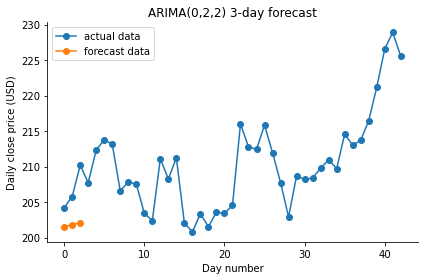

In [7]:
# Plot forecast data
fig, ax = plt.subplots( tight_layout=True)
ax.plot(stock_price[test_date], marker='o', label="actual data")
ax.plot(ypred, marker='o', label="forecast data")
ax.set_xlabel("Day number")
ax.set_ylabel("Daily close price (USD)")
ax.set_title("ARIMA(0,2,2) 3-day forecast")
ax.legend(loc="best")
sns.despine(fig=fig)

The 3-day forecast at 7/1/2020 failed to capture the significant rise in price. I will now try to use ARIMA(0,2,2) to do 1-day rolling forecast instead to see if the model is better.

In [8]:
# Model fitting and forecasting
ypred = []
for i in test_ind_all:
    model = ARIMA(stock_price[(i-260):i], order=(4,2,2))
    model_fit = model.fit()
    ypred.append(model_fit.forecast(steps=1)[0])

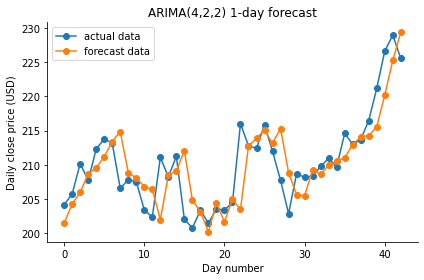

In [9]:
# Plot forecast data
fig, ax = plt.subplots( tight_layout=True)
ax.plot(stock_price[test_date], marker='o', label="actual data")
ax.plot(ypred, marker='o', label="forecast data")
ax.set_xlabel("Day number")
ax.set_ylabel("Daily close price (USD)")
ax.set_title("ARIMA(4,2,2) 1-day forecast")
ax.legend(loc="best")
sns.despine(fig=fig)

The ARIMA model's prediction lags the actual price by 1 day. Thus, the model is not useful.

#### Forecast daily change

Let us try forecasting the daily change in stock price next.

In [10]:
# Daily change
stock_change = np.diff(stock_price)
stock_change = np.insert(stock_change, 0, 0)

# Grid search for optimal parameters
validate_date = (stock_date >= datetime.fromisoformat("2020-06-01"))
SSR = {}
for p in range(5):
    for d in range(3):
        for q in range(3):
            if (p==0) & (d==0) & (q==0):
                continue
            
            SSR_temp = []
            for i in np.arange(stock_date.shape[0])[validate_date][:10]:
                model = ARIMA(stock_change[(i-260):i], order=(p,d,q))
                model_fit = model.fit()
                ypred = model_fit.forecast(steps=3)
                SSR_temp.extend(list((ypred - stock_price[i:(i+3)])**2))
                
            SSR[(p,d,q)] = np.sum(np.array(SSR_temp))

Best parameters: (p,d,q) = (4, 2, 0)


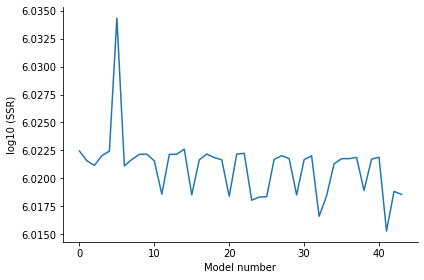

In [11]:
# Plot all SSR
fig, ax = plt.subplots(tight_layout=True)
ax.plot(np.log10(list(SSR.values())))
ax.set_xlabel("Model number")
ax.set_ylabel("log10 (SSR)")
sns.despine(fig=fig)

# Return best parameters
temp = [k for k,v in SSR.items() if v==np.min(list(SSR.values()))]
print(f"Best parameters: (p,d,q) = {temp[0]}")

Test 3-day forecast after 7/1/2020 again.

In [12]:
# Test data
test_date = (stock_date >= datetime.fromisoformat("2020-07-01"))
test_ind_all = np.arange(stock_change.shape[0])[test_date]
test_ind = test_ind_all[0]
model = ARIMA(stock_change[(test_ind-260):test_ind], order=(4,2,0))
model_fit = model.fit()
ypred = model_fit.forecast(steps=3)

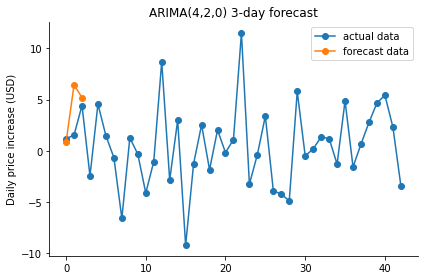

In [13]:
# Plot forecast data
fig, ax = plt.subplots( tight_layout=True)
ax.plot(stock_change[test_date], marker='o', label="actual data")
ax.plot(ypred, marker='o', label="forecast data")
ax.set_ylabel("Daily price increase (USD)")
ax.set_title("ARIMA(4,2,0) 3-day forecast")
ax.legend(loc="best")
sns.despine(fig=fig)

The forecast data is significantly different from the actual data. 

In [14]:
# 1-day forecast
ypred = []
for i in test_ind_all:
    model = ARIMA(stock_change[(i-260):i], order=(4,2,0))
    model_fit = model.fit()
    ypred.append(model_fit.forecast(steps=1)[0])

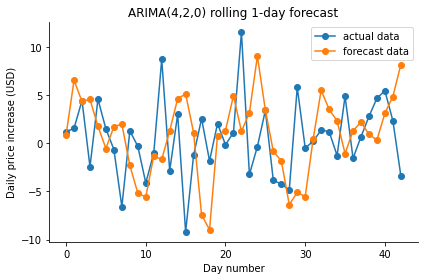

In [15]:
# Plot forecast data
fig, ax = plt.subplots( tight_layout=True)
ax.plot(stock_change[test_date], marker='o', label="actual data")
ax.plot(ypred, marker='o', label="forecast data")
ax.set_xlabel("Day number")
ax.set_ylabel("Daily price increase (USD)")
ax.set_title("ARIMA(4,2,0) rolling 1-day forecast")
ax.legend(loc="best")
sns.despine(fig=fig)

The forecast data lags the actual data by 1 day again. Next, I will use machine learning to incorporate more data and features, with the hope that this will lead to more accurate prediction.

## Feature selection

In this section, I will look for features that are relevant to stock price's movement.

#### Data exploration

The autocorrelation function of the daily stock price is shown below.

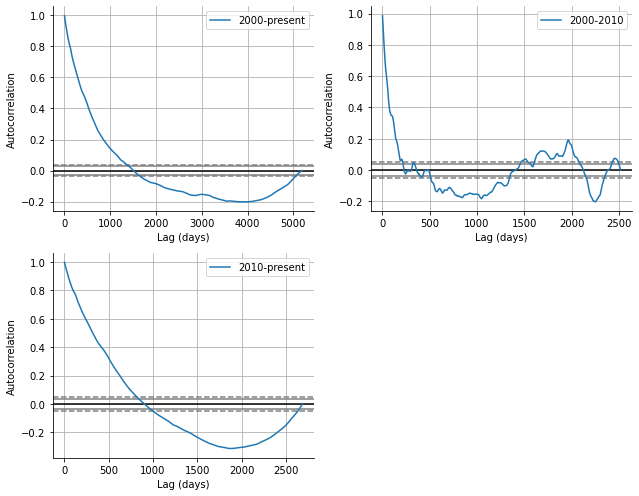

In [16]:
stock_half_range = (stock_hist.index < datetime.fromisoformat("2010-01-01")) # first 10 years

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,7),tight_layout=True)
pd.plotting.autocorrelation_plot(stock_hist["Close"], ax=ax[0,0], label="2000-present")
pd.plotting.autocorrelation_plot(stock_hist.loc[stock_half_range,"Close"], ax=ax[0,1], label="2000-2010")
pd.plotting.autocorrelation_plot(stock_hist.loc[~stock_half_range,"Close"], ax=ax[1,0], label="2010-present")
ax[0,0].set_xlabel("Lag (days)")
ax[0,1].set_xlabel("Lag (days)")
ax[1,0].set_xlabel("Lag (days)")
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

The autocorrelation plot shows that the full range data is autocorrelated at lag below 1,500 days. For 2010-present, the autocorrelation function is significant below approximately 900 days, and has a similar trend to that of the full range data. In contrast, the range 2000-2010 was only significantly autocorrelated below 100 days, and has a different shape than the full range data. This is probably because of the exponential growth dominating much of the 2010-present range, making that the trend more similar to the full range data. This mean that we need to be careful in choosing the training and validation data for the machine learning model later on.

Next, I will perform Fourier transform on the data to visualize any distinct cyclical pattern.

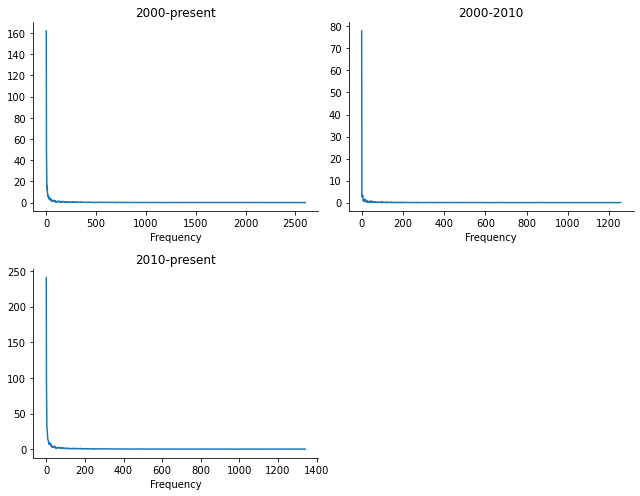

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,7),tight_layout=True)
fft_list = [stock_price, stock_price[stock_half_range], stock_price[~stock_half_range]]
for counter, value in enumerate(fft_list):
    i = counter // 2
    j = counter % 2
    y_fft = np.fft.fft(value)
    Nf = value.shape[0] // 2
    ax[i,j].plot(np.abs(y_fft[:Nf]/(Nf/2)))
    ax[i,j].set_xlabel("Frequency")
ax[0,0].set_title("2000-present")
ax[0,1].set_title("2000-2010")
ax[1,0].set_title("2010-present")
fig.delaxes(ax[1,1])
sns.despine(fig=fig)

There doesn't seem to be any periodicity to the stock price over a long period.

Next is the daily change in stock price, and the daily return percentage.

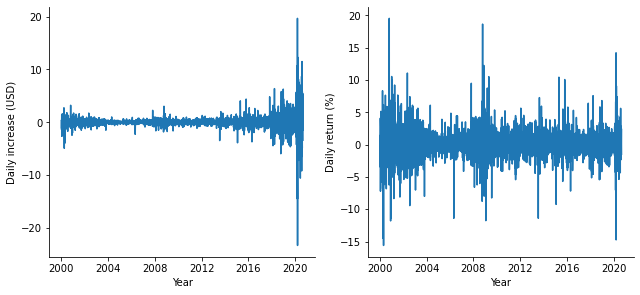

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(9,4.2), tight_layout=True)
# Daily change
ax[0].plot(stock_date[1:], np.diff(stock_price))
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Daily increase (USD)")
ax[1].plot(stock_date[1:], np.diff(stock_price)/stock_price[:-1]*100)
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Daily return (%)")
sns.despine(fig=fig)

The magnitude of the daily return rate is more uniform over the years than the daily increase in price, especially after 2016 where the magnitude of the daily has been steadily increasing. Therefore, the daily return rate will be added as a feature.

The following market information will be used as features:
* The S&P500 and Dow indices (measured by ^GSPC and ^DJI respectively).
* US 10-year treasury yield rate (measured by ^TNX).
* US dollar strength (measured by DX-Y.NYB).
* Market volatility (measured by ^VIX).

The following common stock indicators will also be used:
* Moving average of 5, 10 and 30 days.
* On balance volume.
* 10-day momentum.

I will also add a time feature, defined as the number of trading days since the start of 2000.

#### Adding selected features

In [19]:
# Daily return rate
return_rate = np.diff(stock_price)/stock_price[:-1]*100
return_rate = np.insert(return_rate, 0, np.nan)

# Download the indices
my_ind = yf.download("^GSPC ^DJI ^TNX DX-Y.NYB ^VIX", start="2000-01-01", period="1d")
my_ind = my_ind["Close"]

# Moving averages
ma5 = stock_hist["Close"].rolling(5).mean().to_numpy()
ma10 = stock_hist["Close"].rolling(10).mean().to_numpy()
ma30 = stock_hist["Close"].rolling(30).mean().to_numpy()
# On balance volume
obv = stock_hist["Volume"].to_numpy()
obv[1:] = obv[1:]*np.sign(stock_price[1:]-stock_price[:-1])
obv = np.cumsum(obv)
# 10-day momentum
momentum10 = np.empty(stock_price.shape)
momentum10[:10] = np.nan
momentum10[10:] = stock_price[10:] - stock_price[:-10]

# Time
t = np.arange(stock_price.shape[0])

[*********************100%***********************]  5 of 5 completed


The index data will have to be cleaned up, because some indices don't match up with the dates of stock price.

In [20]:
# Only keep the dates that also appear in stock price
my_ind = my_ind.loc[stock_hist.index,:]
# Fill missing data with linear interpolation
my_ind.interpolate(axis=0, inplace=True)

# Combine all features into one array
X_features = (np.vstack((stock_price, t, return_rate, ma5, ma10, ma30, obv, momentum10))).T
X_features = np.hstack((X_features, my_ind.to_numpy()))
# List of feature names
feature_names = ["Previous price", "Time", "Return rate", "MA(5)", "MA(10)", "MA(30)", "On balance volume",
                "10-day momentum", "S&P500", "Dow Jones", "10-year treasury", "USD index", "Market volatility"]

# Remove the first 30 days, because MA(30) is only available from the 31st day onward
X_features = X_features[30:,:]

# Extract the dates
X_date = stock_hist.index[30:]

# Feature array: remove the last time point of X_features
X = X_features[:-1,:]
# Variable of interest: remove the first time point of stock_price
Y = X_features[1:,0].reshape(-1,1)

## Support vector regression (SVR)

I tried SVR first, but the model took too long to compute, even for 30 training samples.

In [21]:
# from sklearn.svm import SVR

# # Linear kernel
# svr_lin = SVR(kernel='linear', C=10)
# svr_lin.fit(X[-30:-10,:], Y[-30:-10])

## Stochastic gradient descent linear regression

#### 1-day forecast

Next, I will try SGD regression, which is more suitable for large sample size. I will use epsilon_insensitive loss function, because I think that it is more robust towards unaccounted fluctuations in stock price (for example, the public hype). I will use the L1 penalty because I also want to minimize features that are not predictive.

In [22]:
from sklearn.linear_model import SGDRegressor

# Train data sets using all data up until the last 30 days
X_train = X[:-30,:]
Y_train = Y[:-30,:]

# Standardize data
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
Y_scaler = StandardScaler()
Y_scaler.fit(Y_train)
Y_train_scaled = Y_scaler.fit_transform(Y_train)

# Train SGDRegressor
sgdregressor = SGDRegressor(loss='epsilon_insensitive', penalty='l1', random_state=1, verbose=1)
sgdregressor.fit(X_train_scaled, Y_train_scaled)

-- Epoch 1
Norm: 0.48, NNZs: 13, Bias: -0.012156, T: 5138, Avg. loss: 0.005384
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.48, NNZs: 13, Bias: -0.012755, T: 10276, Avg. loss: 0.001633
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.48, NNZs: 13, Bias: -0.012470, T: 15414, Avg. loss: 0.001557
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 12, Bias: -0.009791, T: 20552, Avg. loss: 0.001435
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 0.48, NNZs: 13, Bias: -0.010573, T: 25690, Avg. loss: 0.001442
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 0.49, NNZs: 13, Bias: -0.009678, T: 30828, Avg. loss: 0.001339
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 0.50, NNZs: 11, Bias: -0.006687, T: 35966, Avg. loss: 0.001309
Total training time: 0.01 seconds.
Convergence after 7 epochs took 0.01 seconds


SGDRegressor(loss='epsilon_insensitive', penalty='l1', random_state=1,
             verbose=1)

SSR of forecast data: 509.50


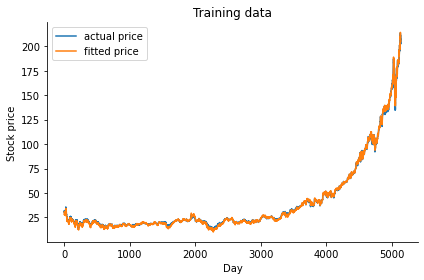

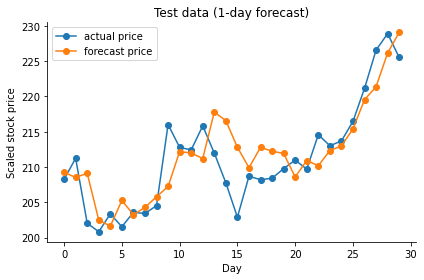

In [23]:
# Plot predicted training data
Y_train_pred = sgdregressor.predict(X_train_scaled)
fig, ax = plt.subplots(tight_layout=True)
ax.plot(Y_train, label="actual price")
ax.plot(Y_scaler.inverse_transform(Y_train_pred), label="fitted price")
ax.set_xlabel("Day")
ax.set_ylabel("Stock price")
ax.legend(loc='best')
ax.set_title("Training data")
sns.despine(fig=fig)

# Test data
X_test = X_scaler.transform(X[-30:,:])
Y_test = Y_scaler.transform(Y[-30:,:])
Y_test_pred = sgdregressor.predict(X_test)

# Plot forecast data
Y_test_pred_unscale = Y_scaler.inverse_transform(Y_test_pred)
fig, ax = plt.subplots(tight_layout=True)
ax.plot(Y[-30:,0], marker='o', label="actual price")
ax.plot(Y_test_pred_unscale, marker='o', label="forecast price")
ax.set_xlabel("Day")
ax.set_ylabel("Scaled stock price")
ax.legend(loc='best')
ax.set_title("Test data (1-day forecast)")
sns.despine(fig=fig)

# Calculate SSR
print(f"SSR of forecast data: {np.sum((Y_test_pred_unscale-Y[-30:,0])**2):.2f}")

The forecast data above was obtained by training the model once using all data points up until the last 30 days. The forecast data's trend lags behind the actual price by 1 day again.

In the plot below, the forecast data is obtained by retraining the model in a 260-day (approximately 1 year of business days) rolling window.

SSR of forecast data: 614.97


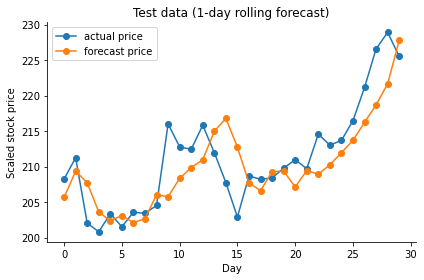

In [24]:
# Rolling forecast
Y_forecast = []
SSR = []
for i in np.arange(X.shape[0])[-30:]:
    # Standardize training data
    X_scaler = StandardScaler()
    X_scaler.fit(X[(i-260):i,:])
    X_train_scaled = X_scaler.transform(X[(i-260):i,:])
    Y_scaler = StandardScaler()
    Y_scaler.fit(Y[(i-260):i,:])
    Y_train_scaled = Y_scaler.fit_transform(Y[(i-260):i,:])
    
    sgdregressor_rolling = SGDRegressor(loss='epsilon_insensitive', penalty='l1', random_state=1)
    sgdregressor_rolling.fit(X_train_scaled, Y_train_scaled)
    X_forecast = X_scaler.transform(X[i,:].reshape(1,-1))
    Y_forecast_temp = Y_scaler.inverse_transform(sgdregressor_rolling.predict(X_forecast))[0]
    Y_forecast.append(Y_forecast_temp)
    SSR.append(Y_forecast_temp-Y[i,0])

# Plot forecast data
fig, ax = plt.subplots(tight_layout=True)
ax.plot(Y[-30:,:], marker='o', label="actual price")
ax.plot(Y_forecast, marker='o', label="forecast price")
ax.set_xlabel("Day")
ax.set_ylabel("Scaled stock price")
ax.legend(loc='best')
ax.set_title("Test data (1-day rolling forecast)")
sns.despine(fig=fig)

# Calculate SSR
print(f"SSR of forecast data: {np.sum(np.array(SSR)**2):.2f}")

The rolling forecast data is slightly better than the non-rolling model (lower SSR). Let us look at the effects of each feature of the non-rolling model.

In [25]:
print(pd.Series(sgdregressor.coef_, index=feature_names))

Previous price       0.255370
Time                 0.002015
Return rate          0.000000
MA(5)                0.248623
MA(10)               0.244947
MA(30)               0.221719
On balance volume    0.023633
10-day momentum      0.026485
S&P500               0.005313
Dow Jones            0.001569
10-year treasury     0.013500
USD index           -0.026658
Market volatility    0.000000
dtype: float64


The stock price is positively correlated with previous day stock price the most, followed by the moving averages. This is unsurprising, because model's forecast lags 1 day behind the actual price, and the moving averages are also strong dependent on the previous stock price.

The model can be improved further by using a validation data set to look for the best rolling window length and the model's hyperparameters. However, I will now try to forecast multiple days in advance instead, because I have found that SGD regression is more promising than ARIMA model, and multiple days forecasting is more useful.

#### 5-day forecast

In [26]:
from sklearn.multioutput import MultiOutputRegressor

# Reformat the feature array
X5 = X_features[:-5,:]
# Reformat the outcome array: i-th column is the stock price i days later
Y5 = np.empty((X5.shape[0],5))
for i in range(5):
    Y5[:,i] = X_features[(i+1):(X_features.shape[0]-4+i),0]

# Train the model with all data until the last 30 days
X5_scaler = StandardScaler()
X5_train = X5[:-30,:]
X5_scaler.fit(X5_train)
X5_train_scale = X5_scaler.transform(X5_train)
Y5_scaler = StandardScaler()
Y5_train = Y5[:-30,:]
Y5_scaler.fit(Y5_train)
Y5_train_scale = Y5_scaler.transform(Y5_train)

sgdregressor = SGDRegressor(loss='epsilon_insensitive', penalty='l1', random_state=1)
sgd_multi = MultiOutputRegressor(sgdregressor)
sgd_multi.fit(X5_train_scale, Y5_train_scale)

MultiOutputRegressor(estimator=SGDRegressor(loss='epsilon_insensitive',
                                            penalty='l1', random_state=1))

SSR: 5031.85


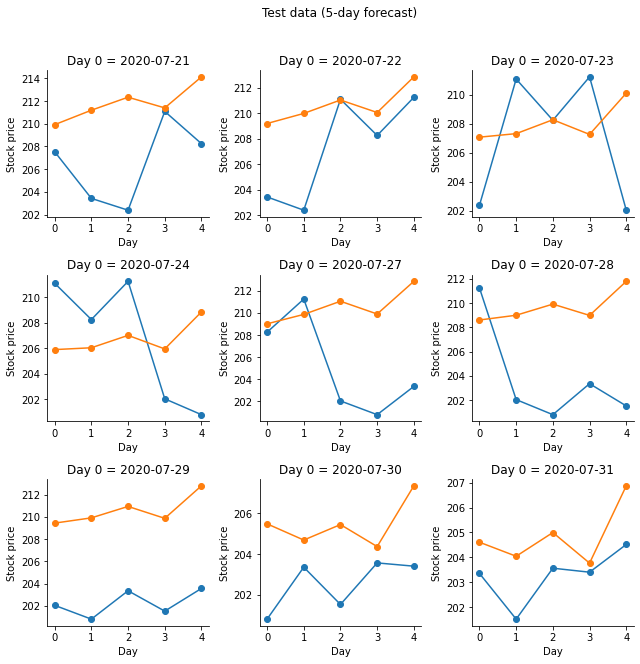

In [27]:
# Forecast
X5_test = X5[-30:,:]
Y5_test = Y5[-30:,:]
Y5_test_pred = sgd_multi.predict(X5_scaler.transform(X5_test))
Y5_test_pred_unscale = Y5_scaler.inverse_transform(Y5_test_pred)

# Plot first nine 5-day forecast
X5_date = X_date[-30:]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), tight_layout=True)
for i in range(9):
    row = i // 3
    col = i % 3
    ax[row,col].plot(Y5_test[i,:], marker='o', label="actual price")
    ax[row,col].plot(Y5_test_pred_unscale[i,:], marker='o', label="forecast price")
    ax[row,col].set_xlabel("Day")
    ax[row,col].set_ylabel("Stock price")
    ax[row,col].set_title(f"Day 0 = {X5_date[i].date()}")
fig.suptitle("Test data (5-day forecast)", x=0.53, y=1.02)
sns.despine(fig=fig)

# Calculate SSR
SSR = np.sum((Y5_test_pred_unscale-Y5_test)**2)
print(f"SSR: {SSR:.2f}")

The 5-day forecast overall is inaccurate. The forecast price and the trend is usually wrong. For some reason, the price is always forecast to increase sharply day 1 and flatten afterwards. I will now try rolling forecast to see if it's more accurate.

In [28]:
Y5_rolling_pred_unscale = []

for i in np.arange(X5.shape[0])[-30:]:
    # Standardize data
    X5_scaler = StandardScaler()
    X5_train = X5[(i-260):i,:]
    X5_scaler.fit(X5_train)
    X5_train_scale = X5_scaler.transform(X5_train)
    Y5_scaler = StandardScaler()
    Y5_train = Y5[(i-260):i,:]
    Y5_scaler.fit(Y5_train)
    Y5_train_scale = Y5_scaler.transform(Y5_train)
    
    X5_test_scale = X5_scaler.transform(X5[i,:].reshape(1,-1))
    
    sgdregressor = SGDRegressor(loss='epsilon_insensitive', penalty='l1', random_state=1)
    sgd_multi = MultiOutputRegressor(sgdregressor)
    sgd_multi.fit(X5_train_scale, Y5_train_scale)
    Y5_test_pred = sgd_multi.predict(X5_test_scale)
    Y5_rolling_pred_unscale.append(Y5_scaler.inverse_transform(Y5_test_pred).flatten())

Rolling forecast SSR: 5244.91


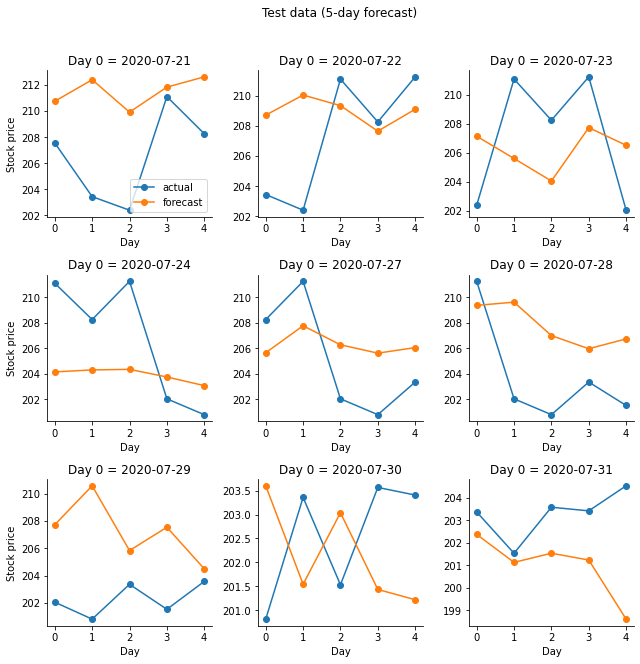

In [29]:
# Plot data
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(9,9), tight_layout=True)
for i in range(9):
    row = i // 3
    col = i % 3
    ax[row,col].plot(Y5_test[i,:], marker='o', label="actual")
    ax[row,col].plot(Y5_rolling_pred_unscale[i], marker='o', label="forecast")
    ax[row,col].set_xlabel("Day")
    if col == 0:
        ax[row,col].set_ylabel("Stock price")
    ax[row,col].set_title(f"Day 0 = {X5_date[i].date()}")
ax[0,0].legend(loc='best')
fig.suptitle("Test data (5-day forecast)", x=0.53, y=1.02)
sns.despine(fig=fig)

# Calculate SSR
SSR = np.sum((np.array(Y5_rolling_pred_unscale)-Y5_test)**2)
print(f"Rolling forecast SSR: {SSR:.2f}")

As before, the rolling forecast data is more accurate, but still not enough to be used by a stock trader.

## Convolutional neural network

While there are other regression models that I could try, such as those based on decision trees, I will go straight to neural network. This is because 1) the convolutional neural network (CNN) can use date from multiple past time points to forecast (ie, memory), and 2) it can theoretically extract features from the stock price without the me specifying them.

To forecast the stock price in the next 5 days, the model will use the data from the previous 30 days. The model will be trained on 260 samples, validated on 60 samples and tested on 30 samples. The test samples will be the most recent 30 days, the validation samples will be the 30 days before the test samples, and the training samples will be the 120 days before the validation samples. I will only use the stock price and the market information as the input features.

In [30]:
rolling_window = 30
cnn_features = X_features[:-5,[0,8,9,10,11,12]] # extract features
cnn_date = stock_hist.index[:-5] # extract date

# Format the input features into array of shape (# samples, rolling window length, # of features)
# The output array has shape (# samples, 5, 1)
# # samples = 260, 60 and 30 for training, validation and test data, respectively
n_train = 260
n_val = 60
n_test = 30
n_features = cnn_features.shape[1]
X_cnn = np.zeros((n_train+n_val+n_test, rolling_window, n_features))
Y_cnn = np.zeros((n_train+n_val+n_test, 5, 1))

# Standardize the data
X_cnn_scaler = StandardScaler()
X_cnn_scaler.fit(cnn_features[-(n_train+n_val+n_test):-(n_val+n_test),:])
Y_cnn_scaler = StandardScaler()
Y_cnn_scaler.fit(cnn_features[-(n_train+n_val+n_test):-(n_val+n_test),0].reshape((-1,1)))

# Reshape the data into 3d array
for counter, i in enumerate(np.arange(cnn_features.shape[0])[-(n_train+n_val+n_test):]):
    X_cnn[counter,:,:] = X_cnn_scaler.transform(cnn_features[(i-rolling_window):i,:])
    Y_cnn[counter,:,:] = Y_cnn_scaler.transform(X_features[i:(i+5),0].reshape((-1,1)))
    
# Extract test, validation and test data
X_cnn_train, X_cnn_val, X_cnn_test = np.split(X_cnn, [n_train,n_train+n_val], axis=0)
Y_cnn_train, Y_cnn_val, Y_cnn_test = np.split(Y_cnn, [n_train,n_train+n_val], axis=0)
train_date, val_date, test_date = np.split(cnn_date[-(n_train+n_val+n_test):], [n_train,n_train+n_val], axis=0)

In [31]:
import tensorflow as tf

# Set up the layers with keras sequential model
CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=30, kernel_size=rolling_window, input_shape=(rolling_window, n_features),
                           kernel_initializer=tf.keras.initializers.GlorotUniform(123)),
    tf.keras.layers.Dense(units=5, kernel_initializer=tf.keras.initializers.GlorotUniform(123)),
    tf.keras.layers.Reshape([5,1])
])
CNN.compile(optimizer='Adam', loss='mape', metrics=['mae','mse'])
CNN_history = CNN.fit(X_cnn_train, Y_cnn_train, validation_data=[X_cnn_val,Y_cnn_val],
                      batch_size=n_train, epochs=500, verbose=2)


Train on 260 samples, validate on 60 samples
Epoch 1/500
260/260 - 1s - loss: 161.4152 - mae: 1.1268 - mse: 2.1164 - val_loss: 93.9709 - val_mae: 2.6541 - val_mse: 9.1430
Epoch 2/500
260/260 - 0s - loss: 136.4007 - mae: 0.9693 - mse: 1.5784 - val_loss: 85.9154 - val_mae: 2.4256 - val_mse: 7.5372
Epoch 3/500
260/260 - 0s - loss: 116.3230 - mae: 0.8290 - mse: 1.1769 - val_loss: 78.7105 - val_mae: 2.2176 - val_mse: 6.2550
Epoch 4/500
260/260 - 0s - loss: 101.0866 - mae: 0.7072 - mse: 0.8875 - val_loss: 72.7389 - val_mae: 2.0388 - val_mse: 5.2637
Epoch 5/500
260/260 - 0s - loss: 89.3153 - mae: 0.6069 - mse: 0.6937 - val_loss: 68.3136 - val_mae: 1.8978 - val_mse: 4.5475
Epoch 6/500
260/260 - 0s - loss: 80.4845 - mae: 0.5279 - mse: 0.5782 - val_loss: 65.6307 - val_mae: 1.8010 - val_mse: 4.0820
Epoch 7/500
260/260 - 0s - loss: 74.7077 - mae: 0.4755 - mse: 0.5244 - val_loss: 64.5802 - val_mae: 1.7495 - val_mse: 3.8395
Epoch 8/500
260/260 - 0s - loss: 71.0032 - mae: 0.4460 - mse: 0.5143 - val_l

Epoch 66/500
260/260 - 0s - loss: 26.4183 - mae: 0.2036 - mse: 0.1036 - val_loss: 61.2135 - val_mae: 1.5917 - val_mse: 2.7286
Epoch 67/500
260/260 - 0s - loss: 26.4342 - mae: 0.2026 - mse: 0.1025 - val_loss: 60.5919 - val_mae: 1.5746 - val_mse: 2.6604
Epoch 68/500
260/260 - 0s - loss: 26.0657 - mae: 0.1999 - mse: 0.0995 - val_loss: 59.8284 - val_mae: 1.5545 - val_mse: 2.5852
Epoch 69/500
260/260 - 0s - loss: 26.1499 - mae: 0.1986 - mse: 0.0976 - val_loss: 59.1390 - val_mae: 1.5375 - val_mse: 2.5436
Epoch 70/500
260/260 - 0s - loss: 26.0437 - mae: 0.1979 - mse: 0.0973 - val_loss: 58.7937 - val_mae: 1.5294 - val_mse: 2.5071
Epoch 71/500
260/260 - 0s - loss: 25.4846 - mae: 0.1963 - mse: 0.0957 - val_loss: 58.9209 - val_mae: 1.5331 - val_mse: 2.5068
Epoch 72/500
260/260 - 0s - loss: 26.1991 - mae: 0.1983 - mse: 0.0954 - val_loss: 58.7419 - val_mae: 1.5298 - val_mse: 2.5142
Epoch 73/500
260/260 - 0s - loss: 25.6618 - mae: 0.1967 - mse: 0.0948 - val_loss: 57.7213 - val_mae: 1.5044 - val_mse:

Epoch 131/500
260/260 - 0s - loss: 21.6494 - mae: 0.1705 - mse: 0.0731 - val_loss: 47.1605 - val_mae: 1.2343 - val_mse: 1.7689
Epoch 132/500
260/260 - 0s - loss: 21.2154 - mae: 0.1680 - mse: 0.0725 - val_loss: 47.1782 - val_mae: 1.2339 - val_mse: 1.7750
Epoch 133/500
260/260 - 0s - loss: 21.6355 - mae: 0.1692 - mse: 0.0729 - val_loss: 47.8329 - val_mae: 1.2488 - val_mse: 1.7852
Epoch 134/500
260/260 - 0s - loss: 21.3848 - mae: 0.1683 - mse: 0.0721 - val_loss: 48.1330 - val_mae: 1.2564 - val_mse: 1.8012
Epoch 135/500
260/260 - 0s - loss: 21.6414 - mae: 0.1699 - mse: 0.0726 - val_loss: 47.9612 - val_mae: 1.2535 - val_mse: 1.8198
Epoch 136/500
260/260 - 0s - loss: 21.8459 - mae: 0.1696 - mse: 0.0726 - val_loss: 48.0283 - val_mae: 1.2571 - val_mse: 1.8276
Epoch 137/500
260/260 - 0s - loss: 21.7430 - mae: 0.1705 - mse: 0.0727 - val_loss: 47.5704 - val_mae: 1.2454 - val_mse: 1.7779
Epoch 138/500
260/260 - 0s - loss: 21.7940 - mae: 0.1706 - mse: 0.0724 - val_loss: 47.2972 - val_mae: 1.2391 - 

Epoch 196/500
260/260 - 0s - loss: 19.4148 - mae: 0.1586 - mse: 0.0669 - val_loss: 43.3180 - val_mae: 1.1338 - val_mse: 1.5510
Epoch 197/500
260/260 - 0s - loss: 19.9326 - mae: 0.1606 - mse: 0.0676 - val_loss: 42.4933 - val_mae: 1.1112 - val_mse: 1.5117
Epoch 198/500
260/260 - 0s - loss: 19.6008 - mae: 0.1583 - mse: 0.0672 - val_loss: 42.3035 - val_mae: 1.1055 - val_mse: 1.4919
Epoch 199/500
260/260 - 0s - loss: 19.4231 - mae: 0.1570 - mse: 0.0662 - val_loss: 42.4506 - val_mae: 1.1103 - val_mse: 1.5074
Epoch 200/500
260/260 - 0s - loss: 19.7941 - mae: 0.1576 - mse: 0.0662 - val_loss: 42.3260 - val_mae: 1.1071 - val_mse: 1.5061
Epoch 201/500
260/260 - 0s - loss: 19.7302 - mae: 0.1579 - mse: 0.0666 - val_loss: 43.0206 - val_mae: 1.1247 - val_mse: 1.5296
Epoch 202/500
260/260 - 0s - loss: 19.6960 - mae: 0.1584 - mse: 0.0667 - val_loss: 43.7041 - val_mae: 1.1413 - val_mse: 1.5457
Epoch 203/500
260/260 - 0s - loss: 19.9420 - mae: 0.1595 - mse: 0.0669 - val_loss: 43.4995 - val_mae: 1.1355 - 

Epoch 261/500
260/260 - 0s - loss: 18.6932 - mae: 0.1516 - mse: 0.0640 - val_loss: 41.6799 - val_mae: 1.0857 - val_mse: 1.4598
Epoch 262/500
260/260 - 0s - loss: 18.7707 - mae: 0.1523 - mse: 0.0636 - val_loss: 41.2863 - val_mae: 1.0754 - val_mse: 1.4462
Epoch 263/500
260/260 - 0s - loss: 18.6007 - mae: 0.1515 - mse: 0.0635 - val_loss: 40.7838 - val_mae: 1.0642 - val_mse: 1.4387
Epoch 264/500
260/260 - 0s - loss: 18.7737 - mae: 0.1523 - mse: 0.0642 - val_loss: 41.0078 - val_mae: 1.0714 - val_mse: 1.4360
Epoch 265/500
260/260 - 0s - loss: 18.3381 - mae: 0.1523 - mse: 0.0644 - val_loss: 41.3395 - val_mae: 1.0789 - val_mse: 1.4261
Epoch 266/500
260/260 - 0s - loss: 19.1625 - mae: 0.1544 - mse: 0.0644 - val_loss: 41.4806 - val_mae: 1.0813 - val_mse: 1.4456
Epoch 267/500
260/260 - 0s - loss: 18.8581 - mae: 0.1525 - mse: 0.0640 - val_loss: 41.4430 - val_mae: 1.0801 - val_mse: 1.4723
Epoch 268/500
260/260 - 0s - loss: 19.1668 - mae: 0.1540 - mse: 0.0648 - val_loss: 41.4452 - val_mae: 1.0800 - 

Epoch 326/500
260/260 - 0s - loss: 18.2339 - mae: 0.1487 - mse: 0.0621 - val_loss: 40.5084 - val_mae: 1.0549 - val_mse: 1.4158
Epoch 327/500
260/260 - 0s - loss: 18.6885 - mae: 0.1499 - mse: 0.0628 - val_loss: 41.2079 - val_mae: 1.0741 - val_mse: 1.4421
Epoch 328/500
260/260 - 0s - loss: 18.5787 - mae: 0.1515 - mse: 0.0635 - val_loss: 40.2829 - val_mae: 1.0489 - val_mse: 1.3965
Epoch 329/500
260/260 - 0s - loss: 18.1835 - mae: 0.1491 - mse: 0.0625 - val_loss: 40.3546 - val_mae: 1.0489 - val_mse: 1.4012
Epoch 330/500
260/260 - 0s - loss: 18.6297 - mae: 0.1487 - mse: 0.0621 - val_loss: 41.8082 - val_mae: 1.0847 - val_mse: 1.4650
Epoch 331/500
260/260 - 0s - loss: 18.0090 - mae: 0.1494 - mse: 0.0624 - val_loss: 41.4628 - val_mae: 1.0752 - val_mse: 1.4481
Epoch 332/500
260/260 - 0s - loss: 18.2772 - mae: 0.1482 - mse: 0.0619 - val_loss: 39.9662 - val_mae: 1.0370 - val_mse: 1.3856
Epoch 333/500
260/260 - 0s - loss: 18.3082 - mae: 0.1471 - mse: 0.0613 - val_loss: 39.8972 - val_mae: 1.0379 - 

Epoch 391/500
260/260 - 0s - loss: 17.9029 - mae: 0.1451 - mse: 0.0604 - val_loss: 39.4044 - val_mae: 1.0214 - val_mse: 1.3596
Epoch 392/500
260/260 - 0s - loss: 18.0135 - mae: 0.1443 - mse: 0.0605 - val_loss: 40.1602 - val_mae: 1.0428 - val_mse: 1.3902
Epoch 393/500
260/260 - 0s - loss: 17.6947 - mae: 0.1461 - mse: 0.0615 - val_loss: 40.4899 - val_mae: 1.0520 - val_mse: 1.3980
Epoch 394/500
260/260 - 0s - loss: 17.6496 - mae: 0.1473 - mse: 0.0617 - val_loss: 39.7520 - val_mae: 1.0307 - val_mse: 1.3705
Epoch 395/500
260/260 - 0s - loss: 17.5149 - mae: 0.1444 - mse: 0.0606 - val_loss: 39.4428 - val_mae: 1.0211 - val_mse: 1.3569
Epoch 396/500
260/260 - 0s - loss: 17.3068 - mae: 0.1431 - mse: 0.0601 - val_loss: 38.9054 - val_mae: 1.0076 - val_mse: 1.3312
Epoch 397/500
260/260 - 0s - loss: 17.7768 - mae: 0.1437 - mse: 0.0601 - val_loss: 38.3018 - val_mae: 0.9936 - val_mse: 1.3049
Epoch 398/500
260/260 - 0s - loss: 17.5708 - mae: 0.1439 - mse: 0.0604 - val_loss: 39.4496 - val_mae: 1.0248 - 

Epoch 456/500
260/260 - 0s - loss: 16.9954 - mae: 0.1416 - mse: 0.0593 - val_loss: 38.1450 - val_mae: 0.9894 - val_mse: 1.3032
Epoch 457/500
260/260 - 0s - loss: 17.2246 - mae: 0.1413 - mse: 0.0592 - val_loss: 39.8849 - val_mae: 1.0355 - val_mse: 1.3849
Epoch 458/500
260/260 - 0s - loss: 17.2502 - mae: 0.1439 - mse: 0.0603 - val_loss: 39.9297 - val_mae: 1.0339 - val_mse: 1.3870
Epoch 459/500
260/260 - 0s - loss: 16.8777 - mae: 0.1420 - mse: 0.0593 - val_loss: 38.7041 - val_mae: 0.9999 - val_mse: 1.3379
Epoch 460/500
260/260 - 0s - loss: 17.3528 - mae: 0.1409 - mse: 0.0586 - val_loss: 39.2911 - val_mae: 1.0163 - val_mse: 1.3586
Epoch 461/500
260/260 - 0s - loss: 16.8897 - mae: 0.1411 - mse: 0.0592 - val_loss: 39.2528 - val_mae: 1.0168 - val_mse: 1.3348
Epoch 462/500
260/260 - 0s - loss: 17.2984 - mae: 0.1437 - mse: 0.0600 - val_loss: 38.7485 - val_mae: 1.0052 - val_mse: 1.3284
Epoch 463/500
260/260 - 0s - loss: 17.1126 - mae: 0.1426 - mse: 0.0599 - val_loss: 38.7703 - val_mae: 1.0047 - 

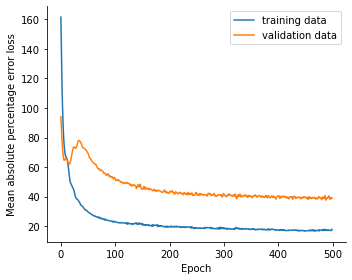

In [32]:
# Plot loss function
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
ax.plot(CNN_history.history['loss'], label='training data')
ax.plot(CNN_history.history['val_loss'], label='validation data')
ax.set_xlabel('Epoch')
ax.set_ylabel("Mean absolute percentage error loss")
ax.legend(loc='upper right')
sns.despine(fig=fig)

The loss on validation date didn't improve beyond approximately 40%. Let us evaluate the model on test data.

In [33]:
print(CNN.summary())
print("Loss on test data:")
CNN.evaluate(X_cnn_test, Y_cnn_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 30)             5430      
_________________________________________________________________
dense (Dense)                (None, 1, 5)              155       
_________________________________________________________________
reshape (Reshape)            (None, 5, 1)              0         
Total params: 5,585
Trainable params: 5,585
Non-trainable params: 0
_________________________________________________________________
None
Loss on test data:
30/30 [==============================] - 0s 166us/sample - loss: 14.4715 - mae: 0.5945 - mse: 0.5464


[14.471453666687012, 0.5945242, 0.54636353]

Surprisingly, the loss on test data is actually better than the validation data (~15% compared to ~40%). This could be caused by the the smaller sample size of test data. Let us now plot the forecast data.

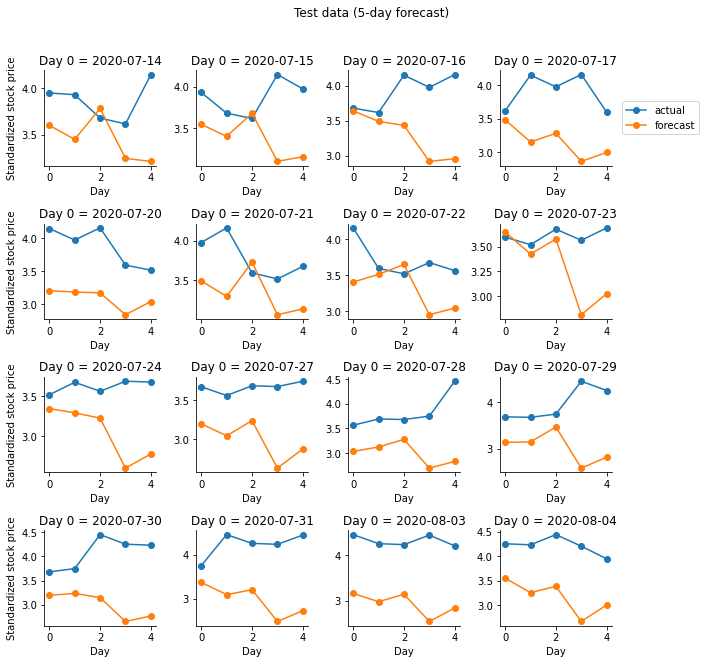

In [34]:
# Forecast on test data
Y_forecast = CNN.predict(X_cnn_test)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,9), tight_layout=True)
for i in range(16):
    row = i // 4
    col = i % 4
    ax[row,col].plot(Y_cnn_test[i,:,0], marker='o', label="actual")
    ax[row,col].plot(Y_forecast[i,:,0], marker='o', label="forecast")
    ax[row,col].set_xlabel("Day")
    if col == 0:
        ax[row,col].set_ylabel("Standardized stock price")
    ax[row,col].set_title(f"Day 0 = {test_date[i].date()}")
ax[0,-1].legend(loc='center left', bbox_to_anchor=(1.05,0.5))
fig.suptitle("Test data (5-day forecast)", x=0.53, y=1.02)
sns.despine(fig=fig)

The model consistently underesimtates the future stock price by a large amount. I will now try the following modifications to improve the forecast accuracy.
* Increase filter number and decrease kernel size (rolling window size).
* Introduce additional layers.

In [35]:
# Set up the layers with keras sequential model
CNN2 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, input_shape=(rolling_window, n_features),
                           kernel_initializer=tf.keras.initializers.GlorotUniform(123)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.AveragePooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=5, kernel_initializer=tf.keras.initializers.GlorotUniform(123)),
    tf.keras.layers.Reshape([5,1])
])
CNN2.compile(optimizer='Adam', loss='mape', metrics=['mae','mse'])
CNN2_history = CNN2.fit(X_cnn_train, Y_cnn_train, validation_data=[X_cnn_val,Y_cnn_val],
                        batch_size=n_train, epochs=500, verbose=2)

Train on 260 samples, validate on 60 samples
Epoch 1/500
260/260 - 1s - loss: 129.9579 - mae: 0.9184 - mse: 1.4034 - val_loss: 86.6576 - val_mae: 2.3986 - val_mse: 6.6790
Epoch 2/500
260/260 - 0s - loss: 105.0484 - mae: 0.7355 - mse: 0.9482 - val_loss: 75.0615 - val_mae: 2.0555 - val_mse: 4.9092
Epoch 3/500
260/260 - 0s - loss: 87.5502 - mae: 0.5891 - mse: 0.6935 - val_loss: 66.5271 - val_mae: 1.7966 - val_mse: 3.7188
Epoch 4/500
260/260 - 0s - loss: 79.7104 - mae: 0.4983 - mse: 0.5325 - val_loss: 61.5731 - val_mae: 1.6361 - val_mse: 2.9943
Epoch 5/500
260/260 - 0s - loss: 69.7042 - mae: 0.4305 - mse: 0.4156 - val_loss: 60.0193 - val_mae: 1.5705 - val_mse: 2.6792
Epoch 6/500
260/260 - 0s - loss: 72.1348 - mae: 0.4310 - mse: 0.4479 - val_loss: 60.6411 - val_mae: 1.5696 - val_mse: 2.6243
Epoch 7/500
260/260 - 0s - loss: 75.1175 - mae: 0.4438 - mse: 0.4934 - val_loss: 62.6560 - val_mae: 1.6119 - val_mse: 2.7290
Epoch 8/500
260/260 - 0s - loss: 69.4503 - mae: 0.4227 - mse: 0.4523 - val_los

Epoch 66/500
260/260 - 0s - loss: 35.9169 - mae: 0.2427 - mse: 0.1279 - val_loss: 51.9441 - val_mae: 1.3831 - val_mse: 2.0663
Epoch 67/500
260/260 - 0s - loss: 35.5109 - mae: 0.2358 - mse: 0.1215 - val_loss: 51.6466 - val_mae: 1.3759 - val_mse: 2.0504
Epoch 68/500
260/260 - 0s - loss: 38.0872 - mae: 0.2480 - mse: 0.1335 - val_loss: 51.0102 - val_mae: 1.3581 - val_mse: 2.0027
Epoch 69/500
260/260 - 0s - loss: 37.7048 - mae: 0.2400 - mse: 0.1229 - val_loss: 50.6261 - val_mae: 1.3470 - val_mse: 1.9726
Epoch 70/500
260/260 - 0s - loss: 37.2885 - mae: 0.2419 - mse: 0.1292 - val_loss: 50.7311 - val_mae: 1.3502 - val_mse: 1.9821
Epoch 71/500
260/260 - 0s - loss: 36.1119 - mae: 0.2374 - mse: 0.1225 - val_loss: 50.8336 - val_mae: 1.3540 - val_mse: 1.9941
Epoch 72/500
260/260 - 0s - loss: 36.4103 - mae: 0.2321 - mse: 0.1204 - val_loss: 50.7017 - val_mae: 1.3520 - val_mse: 1.9909
Epoch 73/500
260/260 - 0s - loss: 37.4100 - mae: 0.2399 - mse: 0.1256 - val_loss: 50.3653 - val_mae: 1.3451 - val_mse:

Epoch 131/500
260/260 - 0s - loss: 31.6867 - mae: 0.2101 - mse: 0.0995 - val_loss: 40.2140 - val_mae: 1.0718 - val_mse: 1.3304
Epoch 132/500
260/260 - 0s - loss: 30.1292 - mae: 0.2069 - mse: 0.0954 - val_loss: 39.0872 - val_mae: 1.0443 - val_mse: 1.2760
Epoch 133/500
260/260 - 0s - loss: 30.6136 - mae: 0.2061 - mse: 0.0979 - val_loss: 38.7271 - val_mae: 1.0351 - val_mse: 1.2577
Epoch 134/500
260/260 - 0s - loss: 29.3770 - mae: 0.2091 - mse: 0.1020 - val_loss: 39.0287 - val_mae: 1.0442 - val_mse: 1.2759
Epoch 135/500
260/260 - 0s - loss: 29.6406 - mae: 0.2036 - mse: 0.0947 - val_loss: 39.3328 - val_mae: 1.0516 - val_mse: 1.2878
Epoch 136/500
260/260 - 0s - loss: 29.8018 - mae: 0.2067 - mse: 0.0971 - val_loss: 39.0857 - val_mae: 1.0451 - val_mse: 1.2723
Epoch 137/500
260/260 - 0s - loss: 29.7596 - mae: 0.2030 - mse: 0.0939 - val_loss: 38.2155 - val_mae: 1.0206 - val_mse: 1.2175
Epoch 138/500
260/260 - 0s - loss: 29.5191 - mae: 0.2034 - mse: 0.0934 - val_loss: 37.5465 - val_mae: 1.0002 - 

Epoch 196/500
260/260 - 0s - loss: 26.4425 - mae: 0.1872 - mse: 0.0823 - val_loss: 35.8669 - val_mae: 0.9467 - val_mse: 1.0836
Epoch 197/500
260/260 - 0s - loss: 27.2258 - mae: 0.1920 - mse: 0.0867 - val_loss: 36.1203 - val_mae: 0.9537 - val_mse: 1.0960
Epoch 198/500
260/260 - 0s - loss: 27.9994 - mae: 0.1956 - mse: 0.0884 - val_loss: 35.5397 - val_mae: 0.9380 - val_mse: 1.0612
Epoch 199/500
260/260 - 0s - loss: 27.6537 - mae: 0.1885 - mse: 0.0836 - val_loss: 34.3544 - val_mae: 0.9071 - val_mse: 0.9969
Epoch 200/500
260/260 - 0s - loss: 27.6574 - mae: 0.1912 - mse: 0.0873 - val_loss: 32.7439 - val_mae: 0.8645 - val_mse: 0.9135
Epoch 201/500
260/260 - 0s - loss: 26.3561 - mae: 0.1821 - mse: 0.0804 - val_loss: 32.0321 - val_mae: 0.8456 - val_mse: 0.8740
Epoch 202/500
260/260 - 0s - loss: 27.7368 - mae: 0.1854 - mse: 0.0792 - val_loss: 32.3658 - val_mae: 0.8546 - val_mse: 0.8848
Epoch 203/500
260/260 - 0s - loss: 26.4504 - mae: 0.1843 - mse: 0.0820 - val_loss: 33.3922 - val_mae: 0.8810 - 

Epoch 261/500
260/260 - 0s - loss: 25.9742 - mae: 0.1813 - mse: 0.0793 - val_loss: 29.4662 - val_mae: 0.7792 - val_mse: 0.7736
Epoch 262/500
260/260 - 0s - loss: 25.1310 - mae: 0.1794 - mse: 0.0804 - val_loss: 29.2156 - val_mae: 0.7693 - val_mse: 0.7647
Epoch 263/500
260/260 - 0s - loss: 24.5687 - mae: 0.1747 - mse: 0.0769 - val_loss: 28.6277 - val_mae: 0.7496 - val_mse: 0.7406
Epoch 264/500
260/260 - 0s - loss: 24.5622 - mae: 0.1757 - mse: 0.0782 - val_loss: 29.0799 - val_mae: 0.7581 - val_mse: 0.7578
Epoch 265/500
260/260 - 0s - loss: 25.5196 - mae: 0.1781 - mse: 0.0796 - val_loss: 29.5916 - val_mae: 0.7702 - val_mse: 0.7778
Epoch 266/500
260/260 - 0s - loss: 25.3961 - mae: 0.1769 - mse: 0.0795 - val_loss: 30.6420 - val_mae: 0.7974 - val_mse: 0.8173
Epoch 267/500
260/260 - 0s - loss: 25.4065 - mae: 0.1759 - mse: 0.0773 - val_loss: 31.3213 - val_mae: 0.8169 - val_mse: 0.8439
Epoch 268/500
260/260 - 0s - loss: 25.3754 - mae: 0.1775 - mse: 0.0773 - val_loss: 30.4366 - val_mae: 0.7966 - 

Epoch 326/500
260/260 - 0s - loss: 23.3731 - mae: 0.1685 - mse: 0.0733 - val_loss: 27.1844 - val_mae: 0.7128 - val_mse: 0.6846
Epoch 327/500
260/260 - 0s - loss: 23.1396 - mae: 0.1645 - mse: 0.0687 - val_loss: 26.6140 - val_mae: 0.6988 - val_mse: 0.6607
Epoch 328/500
260/260 - 0s - loss: 23.7395 - mae: 0.1688 - mse: 0.0751 - val_loss: 27.4160 - val_mae: 0.7199 - val_mse: 0.6861
Epoch 329/500
260/260 - 0s - loss: 24.2728 - mae: 0.1730 - mse: 0.0780 - val_loss: 28.0453 - val_mae: 0.7361 - val_mse: 0.7055
Epoch 330/500
260/260 - 0s - loss: 23.6263 - mae: 0.1698 - mse: 0.0708 - val_loss: 27.9743 - val_mae: 0.7339 - val_mse: 0.6974
Epoch 331/500
260/260 - 0s - loss: 23.8057 - mae: 0.1720 - mse: 0.0758 - val_loss: 27.0666 - val_mae: 0.7099 - val_mse: 0.6587
Epoch 332/500
260/260 - 0s - loss: 23.9998 - mae: 0.1731 - mse: 0.0772 - val_loss: 25.7895 - val_mae: 0.6767 - val_mse: 0.6106
Epoch 333/500
260/260 - 0s - loss: 23.4472 - mae: 0.1647 - mse: 0.0712 - val_loss: 25.4419 - val_mae: 0.6681 - 

Epoch 391/500
260/260 - 0s - loss: 23.1645 - mae: 0.1618 - mse: 0.0652 - val_loss: 26.0386 - val_mae: 0.6808 - val_mse: 0.6426
Epoch 392/500
260/260 - 0s - loss: 23.2979 - mae: 0.1634 - mse: 0.0689 - val_loss: 28.5484 - val_mae: 0.7441 - val_mse: 0.7377
Epoch 393/500
260/260 - 0s - loss: 23.3038 - mae: 0.1686 - mse: 0.0746 - val_loss: 30.0046 - val_mae: 0.7802 - val_mse: 0.7951
Epoch 394/500
260/260 - 0s - loss: 22.7994 - mae: 0.1643 - mse: 0.0674 - val_loss: 29.3815 - val_mae: 0.7635 - val_mse: 0.7701
Epoch 395/500
260/260 - 0s - loss: 23.2106 - mae: 0.1645 - mse: 0.0698 - val_loss: 27.5187 - val_mae: 0.7165 - val_mse: 0.6995
Epoch 396/500
260/260 - 0s - loss: 22.9294 - mae: 0.1617 - mse: 0.0693 - val_loss: 26.2547 - val_mae: 0.6863 - val_mse: 0.6533
Epoch 397/500
260/260 - 0s - loss: 23.5061 - mae: 0.1638 - mse: 0.0681 - val_loss: 25.2233 - val_mae: 0.6631 - val_mse: 0.6193
Epoch 398/500
260/260 - 0s - loss: 23.6008 - mae: 0.1681 - mse: 0.0697 - val_loss: 26.1881 - val_mae: 0.6924 - 

Epoch 456/500
260/260 - 0s - loss: 22.0062 - mae: 0.1631 - mse: 0.0655 - val_loss: 22.8442 - val_mae: 0.6070 - val_mse: 0.5326
Epoch 457/500
260/260 - 0s - loss: 22.7517 - mae: 0.1632 - mse: 0.0694 - val_loss: 21.4130 - val_mae: 0.5687 - val_mse: 0.4817
Epoch 458/500
260/260 - 0s - loss: 22.7499 - mae: 0.1604 - mse: 0.0670 - val_loss: 21.5978 - val_mae: 0.5724 - val_mse: 0.4852
Epoch 459/500
260/260 - 0s - loss: 22.2997 - mae: 0.1581 - mse: 0.0654 - val_loss: 22.8863 - val_mae: 0.6044 - val_mse: 0.5273
Epoch 460/500
260/260 - 0s - loss: 23.0674 - mae: 0.1596 - mse: 0.0649 - val_loss: 23.4659 - val_mae: 0.6170 - val_mse: 0.5457
Epoch 461/500
260/260 - 0s - loss: 23.0169 - mae: 0.1612 - mse: 0.0681 - val_loss: 23.8653 - val_mae: 0.6248 - val_mse: 0.5582
Epoch 462/500
260/260 - 0s - loss: 21.7405 - mae: 0.1593 - mse: 0.0670 - val_loss: 23.9448 - val_mae: 0.6255 - val_mse: 0.5611
Epoch 463/500
260/260 - 0s - loss: 22.1284 - mae: 0.1581 - mse: 0.0661 - val_loss: 25.1102 - val_mae: 0.6559 - 

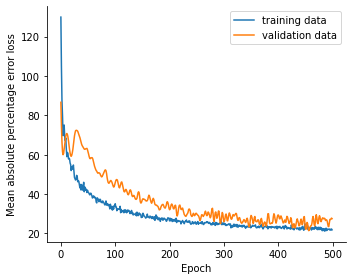

In [36]:
# Plot loss function
fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
ax.plot(CNN2_history.history['loss'], label='training data')
ax.plot(CNN2_history.history['val_loss'], label='validation data')
ax.set_xlabel('Epoch')
ax.set_ylabel("Mean absolute percentage error loss")
ax.legend(loc='upper right')
sns.despine(fig=fig)

In [37]:
print(CNN2.summary())
print("Loss on test data:")
CNN2.evaluate(X_cnn_test, Y_cnn_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 128)           2432      
_________________________________________________________________
dropout (Dropout)            (None, 28, 128)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 14, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 8965      
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 1)              0         
Total params: 11,397
Trainable params: 11,397
Non-trainable params: 0
__________________________________________________

[11.170428276062012, 0.4550728, 0.33371472]

The loss on validation data improved, but the loss on test data is slightly lower than before. Let us plot the forecast on test data.

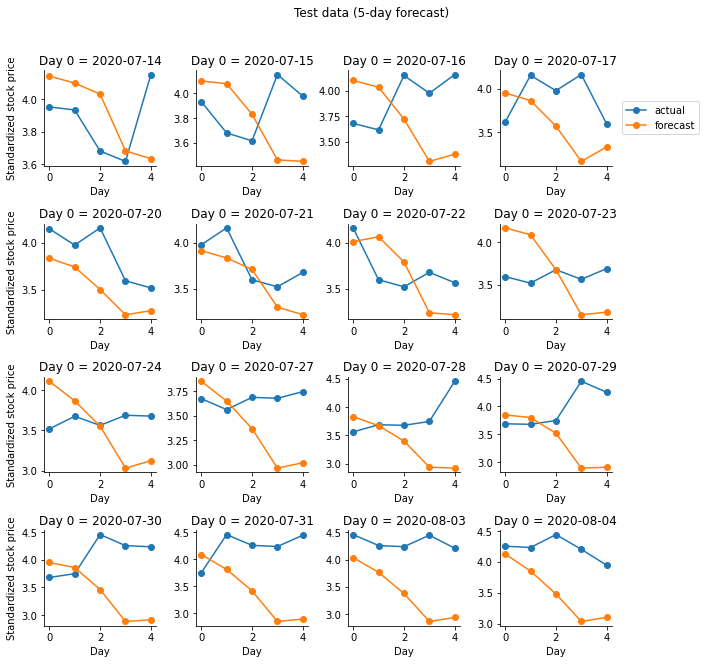

In [38]:
# Forecast on test data
Y_forecast = CNN2.predict(X_cnn_test)
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10,9), tight_layout=True)
for i in range(16):
    row = i // 4
    col = i % 4
    ax[row,col].plot(Y_cnn_test[i,:,0], marker='o', label="actual")
    ax[row,col].plot(Y_forecast[i,:,0], marker='o', label="forecast")
    ax[row,col].set_xlabel("Day")
    if col == 0:
        ax[row,col].set_ylabel("Standardized stock price")
    ax[row,col].set_title(f"Day 0 = {test_date[i].date()}")
ax[0,-1].legend(loc='center left', bbox_to_anchor=(1.05,0.5))
fig.suptitle("Test data (5-day forecast)", x=0.53, y=1.02)
sns.despine(fig=fig)

In [39]:
# Calculate SSR of CNN model
SSR = np.sum((Y_cnn_scaler.inverse_transform(Y_forecast) - Y_cnn_scaler.inverse_transform(Y_cnn_test))**2)
print(f"CNN forecast SSR: {SSR:.2f}")

CNN forecast SSR: 13249.84


The data forecast now shows a consistent decline in stock price over 5 days. The CNN model also has a worse sum of squared residual (SSR) error than the stochastic gradient descent regression model.

Overall, I believe that using the stock price and some market indices along is not sufficient to forecast stock price accurately. Indeed, hedge funds have increasingly seek alternative data in order to assist with their decision making, such as Twitter sentiment and news site traffic. I have not included financial information on the company to my model, such as monthly sales or quarterly revenue. Nevertheless, I doubt that it is possible to produce a stock forecast model that can consistently beat the market in the long run.